In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
import warnings       
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings("ignore")

In [2]:
def prepare_data():
    # verinin okunması
    data = pd.read_csv('EurUsd.csv',low_memory=False)
    # soru işaretleri olan satırlar veriden silindi.
    data = data.replace("?", np.nan)
    data = data.dropna()

    # none değerlerinin atılamsı
    data = drop_none(data, '20_signal')
    
    # verinin feature larının ayrılması
    df_first = data.iloc[:,1:5]
    df_middle = data.iloc[:,5:430]

    result_signal = data.filter(regex = '_signal').astype('category')
    result_numeric = data.filter(regex = '_profitPips')
    
    return df_first, df_middle, result_signal, result_numeric

In [3]:
def drop_none(data, col_name):
    data.drop(index = data[data[col_name]=='NONE'].index, inplace = True)
    return data

In [4]:
def kategorikleri_dummy_yap(df):
    cat_column_names = ['ind_7','ind_11','ind_24','ind_38','ind_54','ind_57','ind_60','ind_63','ind_66','ind_69','ind_72','ind_75',
                    'ind_78','ind_81','ind_84','ind_87','ind_89','ind_91','ind_93','ind_95','ind_97','ind_99','ind_101',
                    'ind_103','ind_105','ind_107','ind_109', 'ind_111', 'ind_113', 'ind_115','ind_138','ind_141','ind_144',
                    'ind_157','ind_159','ind_161','ind_163','ind_165','ind_167','ind_169','ind_171','ind_173','ind_175',
                    'ind_177','ind_182','ind_184','ind_187','ind_190','ind_193','ind_196','ind_199','ind_202','ind_205',
                    'ind_208','ind_211','ind_213','ind_384','ind_386','ind_388','ind_390']
    # categorical kolonların dummy var. oalrak değiştirdik
    dms = pd.get_dummies(df[cat_column_names])
    dms_none_cols = dms.filter(regex = '_NONE').columns
    for i in dms_none_cols:
        dms.drop(i,axis=1,inplace=True)
    dms_red_cols = dms.filter(regex = '_RED').columns
    for i in dms_red_cols:
        dms.drop(i,axis=1,inplace=True)
    #datadan categorical olan kolonları çıkarıyoruz ve type nı değiştiriyoruz
    df_noncategoric = df.drop(cat_column_names,axis=1).astype("float64")
    df_noncategoric = pd.DataFrame(df_noncategoric)
    df_all = pd.concat([df_noncategoric, dms], axis=1)
    # y değerlerinin alınması
    return df_all, df_noncategoric, dms

In [5]:
# 1.1 - dropping correlaritions
def corr_df(df, corr_val):
    corr_matrix = df_noncategoric.corr().abs()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_high = [column for column in upper.columns if any(upper[column] > corr_val)]
    df.drop(to_high, axis = 1, inplace = True)
    return df

In [6]:
# 1.2 RandomForest
# bütün değişkenlerle yapılan random forest sonucu importance değeri verilen parametreden büyük olan değişkenleri döner
def rand_forest(X, y, imp_value):
    rf_model = RandomForestClassifier().fit(X, y)
    Importance = pd.DataFrame({'Importance':rf_model.feature_importances_*100}, index = X.columns)
    imp_values = Importance.sort_values(by = 'Importance', axis = 0, ascending = True)
    imp_values = imp_values[imp_values['Importance']>imp_value]
    col_names = imp_values.index   
    return X[col_names]

In [7]:
# 1.3 - pca
def pca_fon(X, threshold):
    pca = PCA()
    X_pca = pca.fit_transform(scale(X))
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var], index = X.index)
    return X_pcad

In [8]:
def splitting(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    return X_train, X_test, y_train, y_test

In [9]:
# 2.1.1 - multi lojistik
def multi_logit(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
    log = logreg.fit(X_train, y_train)
    y_pred = log.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [10]:
# 2.1.2 - decision tree
def dec_tree(X_train, X_test, y_train, y_test):
    cart = DecisionTreeClassifier()
    cart_model = cart.fit(X_train, y_train)
    y_pred = cart_model.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: ",accuracy)
    print('-------------------------------')
    print("Counfusion matrix: \n",confusion_mat)
    print('-------------------------------')
    print('Classification report')
    print(classification_report(y_test, y_pred))

In [11]:
df_first, df_middle, result_signal, result_numeric = prepare_data()

In [12]:
y_signal = result_signal['20_signal']
y_numeric = result_numeric['20_profitPips']

In [13]:
# 1.1 den gelen veriler (non correlatedlardan gelenler)
df_all, df_noncategoric, dms = kategorikleri_dummy_yap(df_middle)
df_noncorr = corr_df(df_noncategoric, 0.50)
X1 = pd.concat([df_first, df_noncorr, dms], axis=1)
X1.shape

(17760, 204)

In [14]:
# 1.2 den gelen veriler. 
X_raw = pd.concat([df_first,df_all], axis=1) 
X2 = rand_forest(X_raw, y_signal, 0.1)   
X_raw.shape, X2.shape

((17760, 486), (17760, 257))

In [15]:
# 1.3 den gelen veriler.
X_raw2 = pd.concat([df_first,df_all], axis=1) 
X3 = pca_fon(X_raw2, 0.99)
X_raw2.shape, X3.shape

pca sonrası değişken sayısı:  191


((17760, 486), (17760, 191))

In [16]:
X_train1_1, X_test1_1, y_train1_1, y_test1_1 = splitting(X1, y_signal, 0.20)
X_train1_2, X_test1_2, y_train1_2, y_test1_2 = splitting(X1, y_numeric, 0.20)

In [17]:
X_train2_1, X_test2_1, y_train2_1, y_test2_1 = splitting(X2, y_signal, 0.20)
X_train2_2, X_test2_2, y_train2_2, y_test2_2 = splitting(X2, y_numeric, 0.20)

In [18]:
X_train3_1, X_test3_1, y_train3_1, y_test3_1 = splitting(X3, y_signal, 0.20)
X_train3_2, X_test3_2, y_train3_2, y_test3_2 = splitting(X3, y_numeric, 0.20)

# classification

In [19]:
print('Multi lojistik classification')
print('X1_1 *********************************')
multi_logit(X_train1_1, X_test1_1, y_train1_1, y_test1_1)
print('X2_1 *********************************')
multi_logit(X_train2_1, X_test2_1, y_train2_1, y_test2_1)
print('X3_1 *********************************')
multi_logit(X_train3_1, X_test3_1, y_train3_1, y_test3_1)

Multi lojistik classification
X1_1 *********************************
Accuracy:  0.5033783783783784
-------------------------------
Counfusion matrix: 
 [[1021  628]
 [1136  767]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.47      0.62      0.54      1649
        SELL       0.55      0.40      0.47      1903

    accuracy                           0.50      3552
   macro avg       0.51      0.51      0.50      3552
weighted avg       0.51      0.50      0.50      3552

X2_1 *********************************
Accuracy:  0.5219594594594594
-------------------------------
Counfusion matrix: 
 [[ 734  915]
 [ 783 1120]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.48      0.45      0.46      1649
        SELL       0.55      0.59      0.57      1903

    accuracy                           0.52      3552
   macro avg       

In [20]:
print('Dec tree classification')
print('X1_1 *********************************')
dec_tree(X_train1_1, X_test1_1, y_train1_1, y_test1_1)
print('X2_1 *********************************')
dec_tree(X_train2_1, X_test2_1, y_train2_1, y_test2_1)
print('X3_1 *********************************')
dec_tree(X_train3_1, X_test3_1, y_train3_1, y_test3_1)

Dec tree classification
X1_1 *********************************
Accuracy:  0.48592342342342343
-------------------------------
Counfusion matrix: 
 [[ 973  676]
 [1150  753]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.46      0.59      0.52      1649
        SELL       0.53      0.40      0.45      1903

    accuracy                           0.49      3552
   macro avg       0.49      0.49      0.48      3552
weighted avg       0.50      0.49      0.48      3552

X2_1 *********************************
Accuracy:  0.5061936936936937
-------------------------------
Counfusion matrix: 
 [[ 700  949]
 [ 805 1098]]
-------------------------------
Classification report
              precision    recall  f1-score   support

         BUY       0.47      0.42      0.44      1649
        SELL       0.54      0.58      0.56      1903

    accuracy                           0.51      3552
   macro avg       0.50 

# dec tree for X3

In [39]:
# dec tree cross validation with X3_1
cart = DecisionTreeClassifier()
cart_grid = {"max_depth":[20,50,100,150,200,300], "min_samples_split":[30,100,200,300,400,500,750]}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train3_1, y_train3_1)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.3min finished


En iyi parametreler : {'max_depth': 20, 'min_samples_split': 300}


In [40]:
cart = DecisionTreeClassifier(max_depth = 20, min_samples_split=300)
cart_tuned = cart.fit(X_train3_1, y_train3_1)
ypred_train = cart_tuned.predict(X_train3_1)
y_pred3_1 = cart_tuned.predict(X_test3_1)
print('accuracy score for train : ',accuracy_score(y_test3_1, y_pred3_1))
print('class. report for train: ')
print(classification_report(y_train3_1, ypred_train))
print('class. report for test: ')
print(classification_report(y_test3_1, y_pred3_1))

accuracy score for train :  0.5154842342342343
class. report for train: 
              precision    recall  f1-score   support

         BUY       0.66      0.71      0.68      7182
        SELL       0.68      0.63      0.65      7026

    accuracy                           0.67     14208
   macro avg       0.67      0.67      0.67     14208
weighted avg       0.67      0.67      0.67     14208

class. report for test: 
              precision    recall  f1-score   support

         BUY       0.48      0.50      0.49      1649
        SELL       0.55      0.53      0.54      1903

    accuracy                           0.52      3552
   macro avg       0.51      0.51      0.51      3552
weighted avg       0.52      0.52      0.52      3552



# dec tree for X2

In [34]:
# dec tree cross validation with X2_1
cart = DecisionTreeClassifier()
cart_grid = {"max_depth":[20,30,50,75,100,150,200,250,300], "min_samples_split":[20,30,50,75,100,120,150,200,300]}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train2_1, y_train2_1)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  8.1min finished


En iyi parametreler : {'max_depth': 50, 'min_samples_split': 100}


In [41]:
cart = DecisionTreeClassifier(max_depth = 50, min_samples_split=100)
cart_tuned = cart.fit(X_train2_1, y_train2_1)
ypred_train = cart_tuned.predict(X_train2_1)
y_pred2_1 = cart_tuned.predict(X_test2_1)
print('accuracy score for train : ',accuracy_score(y_test2_1, y_pred2_1))
print('class. report for train: ')
print(classification_report(y_train2_1, ypred_train))
print('class. report for test: ')
print(classification_report(y_test2_1, y_pred2_1))

accuracy score for train :  0.5284346846846847
class. report for train: 
              precision    recall  f1-score   support

         BUY       0.85      0.86      0.86      7182
        SELL       0.86      0.84      0.85      7026

    accuracy                           0.85     14208
   macro avg       0.85      0.85      0.85     14208
weighted avg       0.85      0.85      0.85     14208

class. report for test: 
              precision    recall  f1-score   support

         BUY       0.49      0.50      0.49      1649
        SELL       0.56      0.56      0.56      1903

    accuracy                           0.53      3552
   macro avg       0.53      0.53      0.53      3552
weighted avg       0.53      0.53      0.53      3552



# dec tree for X1

In [42]:
# dec tree cross validation with X3_1
cart = DecisionTreeClassifier()
cart_grid = {"max_depth":[20,30,50,75,100,150,200,250,300], "min_samples_split":[20,30,50,75,100,120,150,200,300]}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train1_1, y_train1_1)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.4min finished


En iyi parametreler : {'max_depth': 250, 'min_samples_split': 20}


In [49]:
cart = DecisionTreeClassifier(max_depth = 30, min_samples_split=100)
cart_tuned = cart.fit(X_train1_1, y_train1_1)
ypred_train = cart_tuned.predict(X_train1_1)
y_pred1_1 = cart_tuned.predict(X_test1_1)
print('accuracy score for train : ',accuracy_score(y_test1_1, y_pred1_1))
print('class. report for train: ')
print(classification_report(y_train1_1, ypred_train))
print('class. report for test: ')
print(classification_report(y_test1_1, y_pred1_1))

accuracy score for train :  0.48507882882882886
class. report for train: 
              precision    recall  f1-score   support

         BUY       0.82      0.81      0.81      7182
        SELL       0.81      0.81      0.81      7026

    accuracy                           0.81     14208
   macro avg       0.81      0.81      0.81     14208
weighted avg       0.81      0.81      0.81     14208

class. report for test: 
              precision    recall  f1-score   support

         BUY       0.46      0.63      0.53      1649
        SELL       0.53      0.36      0.43      1903

    accuracy                           0.49      3552
   macro avg       0.49      0.49      0.48      3552
weighted avg       0.50      0.49      0.48      3552



In [50]:
# dec tree cross validation with X3_1
cart = DecisionTreeClassifier()
cart_grid = {"max_depth":[2,5,8,10,20,50,100,200], "min_samples_split":[2,5,10,20,50,100,300]}
cart_cv = GridSearchCV(cart, cart_grid, cv=10, n_jobs =-1, verbose = 2)
cart_cv_model = cart_cv.fit(X_train1_1, y_train1_1)
print('En iyi parametreler : ' + str(cart_cv_model.best_params_))

Fitting 10 folds for each of 56 candidates, totalling 560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   24.4s


En iyi parametreler : {'max_depth': 2, 'min_samples_split': 2}


[Parallel(n_jobs=-1)]: Done 560 out of 560 | elapsed:   46.0s finished


In [53]:
cart = DecisionTreeClassifier(max_depth = 50, min_samples_split=50)
cart_tuned = cart.fit(X_train1_1, y_train1_1)
ypred_train = cart_tuned.predict(X_train1_1)
y_pred1_1 = cart_tuned.predict(X_test1_1)
print('accuracy score for train : ',accuracy_score(y_test1_1, y_pred1_1))
print('class. report for train: ')
print(classification_report(y_train1_1, ypred_train))
print('class. report for test: ')
print(classification_report(y_test1_1, y_pred1_1))

accuracy score for train :  0.47353603603603606
class. report for train: 
              precision    recall  f1-score   support

         BUY       0.86      0.88      0.87      7182
        SELL       0.88      0.85      0.86      7026

    accuracy                           0.87     14208
   macro avg       0.87      0.87      0.87     14208
weighted avg       0.87      0.87      0.87     14208

class. report for test: 
              precision    recall  f1-score   support

         BUY       0.45      0.63      0.53      1649
        SELL       0.51      0.33      0.40      1903

    accuracy                           0.47      3552
   macro avg       0.48      0.48      0.47      3552
weighted avg       0.48      0.47      0.46      3552



# regression

In [23]:
regr1 = DecisionTreeRegressor()
regr1.fit(X_train1_2, y_train1_2)
y_pred_train = regr1.predict(X_train1_2)
y_pred_test = regr1.predict(X_test1_2)
print('train score: ',regr1.score(X_train1_2, y_train1_2, sample_weight=None))
print('test score: ',regr1.score(X_test1_2, y_test1_2, sample_weight=None))

train score:  0.9999999999302109
test score:  -1.229099301212143


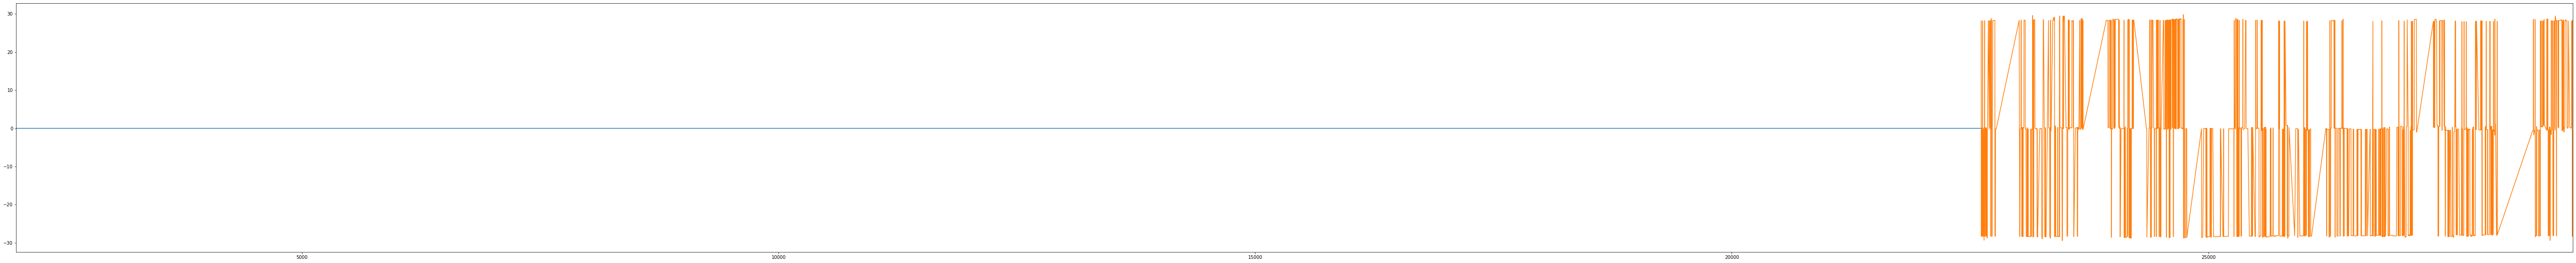

In [24]:
diff_train = y_train1_2 - y_pred_train
diff_test = y_test1_2 - y_pred_test
diff_train.plot(figsize=(100,10))
diff_test.plot(figsize=(100,10))

In [25]:
print('Mean Squared Error - train:', metrics.mean_squared_error(y_train1_2, y_pred_train))
print('Mean Squared Error - test:', metrics.mean_squared_error(y_test1_2, y_pred_test))

Mean Squared Error - train: 1.518940462154079e-08
Mean Squared Error - test: 436.152233028232


In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(250,8))
y_test2, y_pred

x = y_test2.index
y1 =y_test2
y2 =y_pred

plt.scatter(x, y1, c="g", alpha=0.5,
            label="test")
plt.scatter(x, y2, c="b", alpha=0.5,
            label="pred")

plt.legend(loc='upper left')
plt.show()

NameError: name 'y_test2' is not defined

<Figure size 18000x576 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(250,8))
y_test2, y_pred

x = y_test2.index

plt.scatter(x, diff, c="g", alpha=0.5,
            label="test")

plt.legend(loc='upper left')
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(), n_estimators=1000, random_state=np.random.RandomState(1))
regr_2.fit(X_train2, y_train2)
y_pred2 = regr_2.predict(X_test2)
print('train score: ',regr_2.score(X_train2, y_train2, sample_weight=None))
print('test score: ',regr_2.score(X_test2, y_test2, sample_weight=None))

In [ ]:
a = y_test2
diff = y_test2 - y_pred
diff

In [ ]:
param_grid = {'max_depth': [100,200,500],
              'min_samples_split': [100,200,300]}

clf = GridSearchCV(tree.DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=5 , n_jobs=-1, verbose=2)
%time _ = clf.fit(X_train2, y_train2)
print('En iyi parametreler : ' + str(clf .best_params_))

In [ ]:
regr_tuned = DecisionTreeRegressor(max_depth=100,min_samples_split=50)
regr_tuned.fit(X_train2, y_train2)
y_pred_tuned = regr_tuned.predict(X_test2)

In [ ]:
print('train score: ',regr_tuned.score(X_train2, y_train2, sample_weight=None))
print('test score: ',regr_tuned.score(X_test2, y_test2, sample_weight=None))

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=200,min_samples_split=100), n_estimators=1000,learning_rate=0.1, random_state=np.random.RandomState(1))
regr_2.fit(X_train2, y_train2)
y_pred2 = regr_2.predict(X_test2)
print('train score: ',regr_2.score(X_train2, y_train2, sample_weight=None))
print('test score: ',regr_2.score(X_test2, y_test2, sample_weight=None))



In [ ]:
for i in [100,200,300,500]:
    print('//////////////')
    print('max_depth: ', i)
    for j in [100,200,300]:
        print('*****************')
        print('min_samples_split: ', j)
        for k in [200,300,500]:
            print('-------------')
            print('n_estimators: ', k)
            for l in [0.001,0.005,0.05]:
                print('++++++++++++++++')
                print('learning_rate: ', l)
                regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=i,min_samples_split=j), n_estimators=k,learning_rate=l, random_state=np.random.RandomState(1))
                regr_2.fit(X_train2, y_train2)
                y_pred2 = regr_2.predict(X_test2)
                print('train score: ',regr_2.score(X_train2, y_train2, sample_weight=None))
                print('test score: ',regr_2.score(X_test2, y_test2, sample_weight=None))

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train1)

# X_train = scaler.transform(X_train1)
# X_test = scaler.transform(X_test1)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train1, y_train1)
y_pred = classifier.predict(X_test1)

In [ ]:
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train1, y_train1)
y_pred = svclassifier.predict(X_test1)


In [ ]:
print(confusion_matrix(y_test1, y_pred))
print(classification_report(y_test1, y_pred))